In [1]:
from geopyspark import geopyspark_conf
from geopyspark.geotrellis.constants import *
from geopyspark.geotrellis.layer import TiledRasterLayer
from pyspark import SparkContext
import json
import shapely
from shapely.geometry import shape, asShape, MultiPoint, MultiLineString

In [2]:
conf = geopyspark_conf("local[*]", "TMS")
conf.set('spark/ui.enabled', True)
pysc = SparkContext.getOrCreate(conf)

# View NLCD from GeoTrellis Catalog

In [3]:
from geopyspark.geotrellis.tms import *
from geopyspark.geotrellis.color import ColorMap
from geonotebook.wrappers.raster import TMSRasterData

nlcd_layer_name = "nlcd-tms-epsg3857"

nlcd = s3_catalog_tms_server(
    pysc, 
    "azavea-datahub", "catalog", 
    nlcd_layer_name, 
    ColorMap.nlcd_colormap(pysc))

In [4]:
M.add_layer(TMSRasterData(nlcd), name="nlcd")
M.set_center(-120.32, 47.84, 7)

Added TMS server at host 0:0:0:0:0:0:0:0
Added TMS server at port 51560


# Read Chattanooga NLCD Tiles

In [5]:
M.set_center(-85.2934168635424, 35.02445474101138, 9)

In [6]:
!curl -o /tmp/mask.json https://s3.amazonaws.com/geotrellis-demo/chatta/chatta_mask.json

from geonotebook.wrappers import VectorData
vd = VectorData("/tmp/mask.json")
name = "Outline"
M.add_layer(vd, name=name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  571k  100  571k    0     0   988k      0 --:--:-- --:--:-- --:--:--  987k


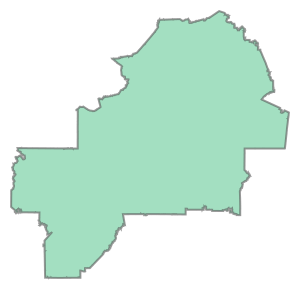

In [7]:
from functools import partial
import fiona
import json
import pyproj
from shapely.geometry import mapping, shape
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'),
    pyproj.Proj(init='epsg:3857'))

txt = open('/tmp/mask.json').read()
js = json.loads(txt)['geometry']
geom = shape(js)
center = geom.centroid
chatta_poly = transform(project, geom)
chatta_poly

## Work with Chattanooga RDD

In [8]:
from geopyspark.geotrellis import catalog

MAX_ZOOM = 12
query_rdd = catalog.query(
    pysc, LayerType.SPATIAL, 
    "s3://azavea-datahub/catalog", nlcd_layer_name, 
    MAX_ZOOM, query_geom=chatta_poly)

chatta_rdd = query_rdd.convert_data_type("int8").cache()

In [9]:
chatta_rdd.get_min_max()

(11.0, 95.0)

In [10]:
(chatta_rdd + 10).get_min_max()

(21.0, 105.0)

In [ ]:
for layer in M.layers:
    M.remove_layer(layer)

In [11]:
chatta_pp = chatta_rdd.pyramid(start_zoom=12, end_zoom=1)


In [12]:
chatta_server = rdd_tms_server(pysc, chatta_pp, ColorMap.nlcd_colormap(pysc))

In [13]:
M.add_layer(TMSRasterData(chatta_server), name="chatta_nlcd")
M.add_layer(vd, name=name)

Added TMS server at host 0:0:0:0:0:0:0:0
Added TMS server at port 61752


In [17]:
M.remove_layer(M.layers[0])

In [16]:
masked = chatta_rdd.mask(geometries=chatta_poly)
chatta_masked_pp = masked.pyramid(start_zoom=12, end_zoom=1)
chatta_masked_server = rdd_tms_server(pysc, chatta_masked_pp, ColorMap.nlcd_colormap(pysc))
M.add_layer(TMSRasterData(chatta_masked_server), name="chatta_nlcd")

Added TMS server at host 0:0:0:0:0:0:0:0
Added TMS server at port 51653


In [18]:
chatta_py_rdd = masked.to_numpy_rdd()
chatta_py_rdd.first()

(SpatialKey(col=1069, row=1629),
 Tile(cells=array([[[81, 81, 81, ..., 81, 81, 81],
        [81, 81, 81, ..., 81, 81, 81],
        [81, 81, 81, ..., 81, 81, 81],
        ..., 
        [81, 81, 81, ..., 82, 82, 82],
        [81, 81, 81, ..., 82, 82, 82],
        [81, 81, 81, ..., 82, 82, 82]]], dtype=int8), cell_type='BYTE', no_data_value=-128.0))

In [19]:
import numpy as np
def get_counts(tile):
    values, counts = np.unique(tile.cells.flatten(), return_counts=True)
    d = {}
    for v, c in zip(values, counts):
        if v != 0: # Remove NoData
            d[v] = c
    return d

def merge_counts(d1, d2):
    d = {}
    for k in set(d1.keys()).union(set(d2.keys())):
        v = 0
        if k in d1:
            v += d1[k]
        if k in d2:
            v += d2[k]
        d[k] = v
    return d

counts = chatta_py_rdd.map(lambda x: get_counts(x[1])).reduce(merge_counts)
counts

{11: 1705782,
 21: 4311658,
 22: 1754228,
 23: 538731,
 24: 242804,
 31: 151266,
 41: 30459362,
 42: 5879852,
 43: 5357079,
 52: 3557739,
 71: 3158742,
 81: 12779780,
 82: 2382675,
 90: 551091,
 95: 52883}

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

labels = {0: 'NoData',
         11: 'Open Water',
         21: 'Developed, Open Space',
         22: 'Developed, Low Intensity',
         23: 'Developed, Medium Intensity',
         24: 'Developed High Intensity',
         31: 'Barren Land (Rock/Sand/Clay)',
         41: 'Deciduous Forest',
         42: 'Evergreen Forest ',
         43: 'Mixed Forest',
         52: 'Shrub/Scrub',
         71: 'Grassland/Herbaceous',
         81: 'Pasture/Hay',
         82: 'Cultivated Crops',
         90: 'Woody Wetlands',
         95: 'Emergent Herbaceous Wetlands'}
named_counts = {}
for k in counts:
    named_counts[labels[k]] = counts[k]

df = pd.DataFrame.from_dict(named_counts,  orient='index')

In [21]:
df

,0
Cultivated Crops,2382675
"Developed, Medium Intensity",538731
Woody Wetlands,551091
Barren Land (Rock/Sand/Clay),151266
Deciduous Forest,30459362
Mixed Forest,5357079
Emergent Herbaceous Wetlands,52883
Open Water,1705782
"Developed, Open Space",4311658
"Developed, Low Intensity",1754228


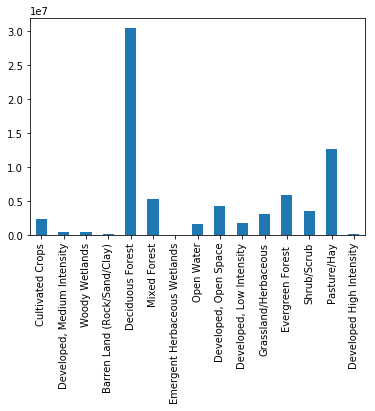

In [22]:
plt.figure()
df.plot.bar(legend=False)
plt.show()